In [1]:
%%capture
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import KFold

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
data = dict(np.load("./data/data.npz"))

In [5]:
L = tf.keras.layers

In [25]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [33]:
def r2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [47]:
def build_model(sequence_units, structure_units):
    input_sequence_feat = L.Input(shape=data["sequence_feat"].shape[1:], name="sequence_feat")
    lstms_sequence_feat = L.LSTM(sequence_units)(input_sequence_feat)
    
    input_sequence_freq = L.Input(shape=data["sequence_freq"].shape[1:], name="sequence_freq")
    dense_sequence_freq = L.Dense(sequence_units, activation="relu")(input_sequence_freq)
    
    input_structure_feat = L.Input(shape=data["structure_feat"].shape[1:], name="structure_feat")
    lstms_structure_feat = L.LSTM(structure_units)(input_structure_feat)
    
    input_structure_freq = L.Input(shape=data["structure_freq"].shape[1:], name="structure_freq")
    dense_structure_freq = L.Dense(structure_units, activation="relu")(input_structure_freq)
    
    concat = L.concatenate([
        lstms_sequence_feat,
        dense_sequence_freq,
        lstms_structure_feat,
        dense_structure_freq
    ])
    
    out_dense0 = L.Dense(32)(concat)
    out_dense1 = L.Dense(1)(out_dense0)
    
    model = tf.keras.Model(
        inputs=[
            input_sequence_feat,
            input_sequence_freq,
            input_structure_feat,
            input_structure_freq
        ],
        outputs=[out_dense1]
    )
    model.compile(optimizer="adam", loss=rmse, metrics=["mae", "mse", r2])
    return model

In [48]:
model = build_model(16, 8)

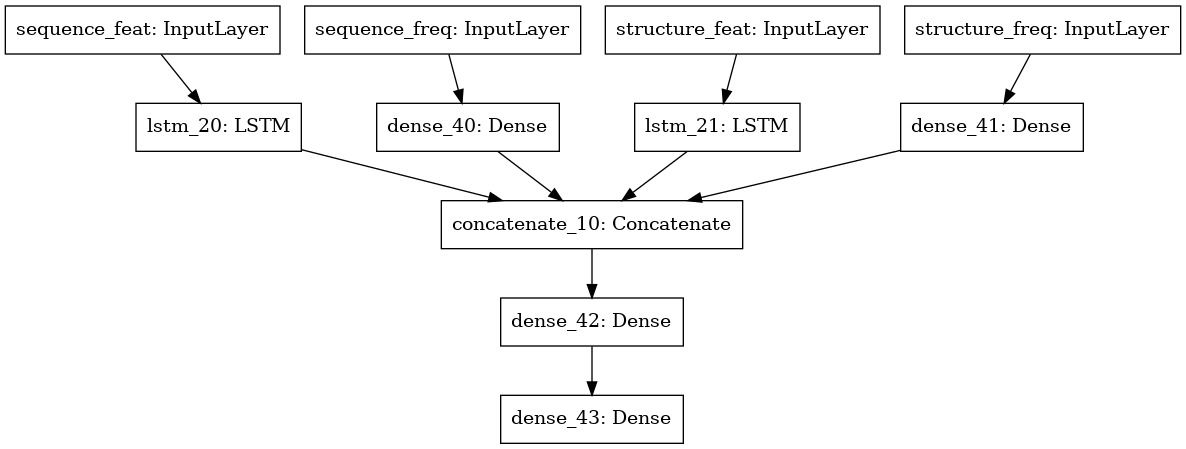

In [49]:
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file="model.png")
Image("model.png")

In [50]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_feat (InputLayer)      [(None, 43, 24)]     0                                            
__________________________________________________________________________________________________
sequence_freq (InputLayer)      [(None, 19)]         0                                            
__________________________________________________________________________________________________
structure_feat (InputLayer)     [(None, 43, 3)]      0                                            
__________________________________________________________________________________________________
structure_freq (InputLayer)     [(None, 3)]          0                                            
___________________________________________________________________________________________

In [51]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

In [52]:
histories = []
evaluates = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(data["sequence_feat"]):
    model = build_model(16, 8)
    X_train = [data[i.name][train_index] for i in model.inputs]
    X_test = [data[i.name][test_index] for i in model.inputs]
    y_train, y_test = data["score"][train_index], data["score"][test_index]
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=int(1e3),
        validation_split=0.10,
        callbacks=[early_stop]
    )
    histories.append(history.history)
    evaluates.append(model.evaluate(X_test, y_test))
    break

Epoch 1/1000
193/193 [==============================] - 5s 12ms/step - loss: 2.2607 - mae: 0.4397 - mse: 0.3414 - rmse: 0.5187 - r2: -1.2606 - val_loss: 0.6118 - val_mae: 0.2368 - val_mse: 0.0976 - val_rmse: 0.3095 - val_r2: 0.3757
Epoch 2/1000
193/193 [==============================] - 2s 9ms/step - loss: 0.5404 - mae: 0.2259 - mse: 0.0843 - rmse: 0.2866 - r2: 0.4595 - val_loss: 0.4816 - val_mae: 0.2132 - val_mse: 0.0758 - val_rmse: 0.2743 - val_r2: 0.5029
Epoch 3/1000
193/193 [==============================] - 2s 9ms/step - loss: 0.4712 - mae: 0.2043 - mse: 0.0718 - rmse: 0.2647 - r2: 0.5288 - val_loss: 0.4573 - val_mae: 0.1980 - val_mse: 0.0722 - val_rmse: 0.2674 - val_r2: 0.5223
Epoch 4/1000
193/193 [==============================] - 2s 9ms/step - loss: 0.4429 - mae: 0.1898 - mse: 0.0661 - rmse: 0.2545 - r2: 0.5571 - val_loss: 0.4246 - val_mae: 0.1899 - val_mse: 0.0670 - val_rmse: 0.2580 - val_r2: 0.5561
Epoch 5/1000
193/193 [==============================] - 2s 9ms/step - loss: 0.

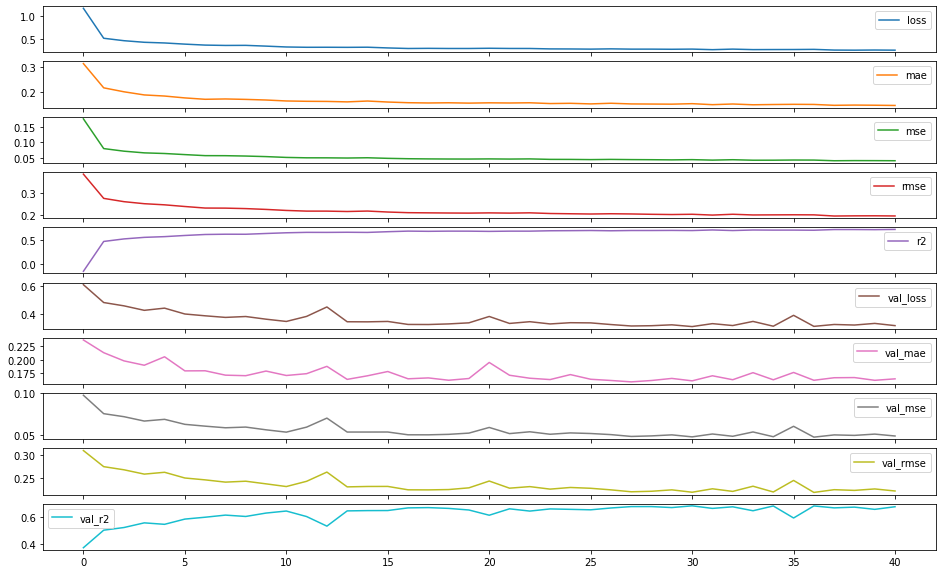

In [57]:
_ = pd.DataFrame(histories[0]).plot(subplots=True, figsize=(16, 10))

In [54]:
pd.DataFrame(evaluates[0])

,0
0,0.280038
1,0.156482
2,0.044620
3,0.207243
4,0.719241


In [55]:
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.00000,0.85673
predicted,0.85673,1.00000
